In [1]:
from psaw import PushshiftAPI
import praw
from prawcore import Forbidden
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

from scipy import stats

from pymongo import MongoClient, errors
from bson.json_util import loads, dumps
from bson.objectid import ObjectId

from datetime import datetime as dt

import boto3

import time

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc
from sklearn.inspection import permutation_importance, plot_partial_dependence

from imblearn.ensemble import BalancedRandomForestClassifier

from scipy import interp

import string

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
porter = PorterStemmer()
wordnet = WordNetLemmatizer()

In [4]:
client = MongoClient('localhost', 27017)
db = client['cap2']
table = db['first_and_last']

In [5]:
db.list_collection_names()

['submission', 'first_and_last', 'comment']

In [6]:
# count number of documents per collection
for coll in db.list_collection_names():
    print(f'{coll:14}: {db[coll].count_documents({}):6}')

submission    :  14523
first_and_last:    952
comment       : 230853


## Bring in the data from mongo

In [7]:
query = {}
fields = { '_id': 0 }
# docs is about 1.3 GB in RAM
docs = list(db['comment'].find( query, fields ))

In [8]:
# comms is about 100 MB in RAM
comms = pd.DataFrame(docs)

In [9]:
comms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230853 entries, 0 to 230852
Data columns (total 71 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   author                           6704 non-null    object 
 1   author_created_utc               6597 non-null    float64
 2   author_flair_css_class           57434 non-null   object 
 3   author_flair_text                58619 non-null   object 
 4   author_fullname                  201891 non-null  object 
 5   body                             230853 non-null  object 
 6   controversiality                 230219 non-null  float64
 7   created_utc                      230853 non-null  float64
 8   distinguished                    380 non-null     object 
 9   gilded                           230215 non-null  float64
 10  id                               230853 non-null  object 
 11  link_id                          230853 non-null  object 
 12  ne

In [10]:
stopwords_ = set("a,able,about,across,after,all,almost,also,am,among,an,and,any,\
are,as,at,be,because,been,but,by,can,could,dear,did,do,does,either,\
else,ever,every,for,from,get,got,had,has,have,he,her,hers,him,his,\
how,however,i,if,in,into,is,it,its,just,least,let,like,likely,may,\
me,might,most,must,my,neither,no,of,off,often,on,only,or,other,our,\
own,rather,said,say,says,she,should,since,so,some,than,that,the,their,\
them,then,there,these,they,this,tis,to,too,twas,us,wants,was,we,were,\
what,when,where,which,while,who,whom,why,will,with,would,yet,you,your,u,s".split(','))

punctuation_ = set(string.punctuation + '’' + '“')

def rm_punctuation(a_string):
    table = str.maketrans('', '', ''.join(punctuation_))
    return a_string.translate(table)
        
def tokens_lower(tokens):
    return [word.lower() for word in tokens]

def filter_tokens(tokens):
#     for w in sent: print(w)
#     if w == "’": print("this is ': " + w)
    return [w for w in tokens if not w in stopwords_]

def stem_tokens(ntlk_stem_obj, tokens):
    # visualize what stemming and lemmitization does!
    # str(porter.__class__) = "<class 'nltk.stem.porter.PorterStemmer'>"
#     name = str(ntlk_stem_lemm_obj.__class__).split("'")[1].split('.')[-1]
#     count_ident = 0
#     count_alter = 0
    return [ntlk_stem_obj.stem(tok) for tok in tokens]
#     elif ''
# for tok in tokens:
#         return ntlk_stem_lemm_obj.stem(tok)
#         if tok == stem_lemm_f_l_tok:
#             count_ident += 1
#         else:
#             print(tok, stem_lemm_f_l_tok)
#             count_alter += 1
#     print('{}:\nNumber of unchanged words: {}\nchanged words: {}\n'.format(name, count_ident, count_alter))

def lemm_tokens(ntlk_lemm_obj, tokens):
    return [ntlk_lemm_obj.lemmatize(tok) for tok in tokens]

In [11]:
def nlp_pre_proc_doc(input_string, stemming=False):
    '''
    given document:
        tokenizes the document
        sets tokens to lower case
        filters punctuation and stop words from tokens
        returns porter, snowball, and wordnet stem/lemm tokens
    '''
    no_punct_string = rm_punctuation(input_string)
    tokens = word_tokenize(no_punct_string)
    lo_tokens = tokens_lower(tokens)
    f_lo_tokens = filter_tokens(lo_tokens)
    if stemming:
        s_f_lo_tokens = stem_tokens(porter, f_lo_tokens)
        le_s_f_lo_tokens = lemm_tokens(wordnet, s_f_lo_tokens)
        return ' '.join(le_s_f_lo_tokens)
    else:
        le_f_lo_tokens = lemm_tokens(wordnet, f_lo_tokens)
        return ' '.join(le_f_lo_tokens)

In [12]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [13]:
# this takes a few minutes, and uses about 100 MB of RAM
corpus = [nlp_pre_proc_doc(d) for d in comms['body']]

In [54]:
# vectorize on all the data (ok for unsupervised learning)

n_samples = len(corpus)
n_features = 500
n_topics = 15
n_top_words = 10

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')

In [55]:
t0 = time.time()
tfidf = tfidf_vectorizer.fit_transform(corpus)
print("done in %0.3fs." % (time.time() - t0))

done in 3.417s.


In [56]:
# Fit the NMF model
print("Fitting the NMF model with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time.time()
nmf = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5, ).fit(tfidf)
print("done in %0.3fs." % (time.time() - t0))

print("\nTopics in NMF model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Fitting the NMF model with tf-idf features, n_samples=230853 and n_features=500...
done in 26.293s.

Topics in NMF model:
Topic #0:
thanks giveaway doing man chance awesome lot dude luck great
Topic #1:
deleted comment post account mod thread app reddit update article
Topic #2:
time really make guy think thing year need day going
Topic #3:
op thanks happy youre nice mad birthday best luck awesome
Topic #4:
im sure going sorry pretty na glad gon win happy
Topic #5:
look great cat doesnt amazing face awesome pretty cool picture
Topic #6:
good luck brother job news pretty thing bad looking idea
Topic #7:
game play win steam happy pc played playing want fun
Topic #8:
thank giveaway doing awesome god happy kind nice win amazing
Topic #9:
love id play dog copy cat awesome giveaway life great
Topic #10:
dont know want think understand care mean believe use need
Topic #11:
removed post rule comment question content page reason thread bot
Topic #12:
people think lot money black actually underst

## Train classifier(s)

In [57]:
# keep a dictionary of trained classifiers for comparison
clfs = {}

### random forest
Spoke with Dan. He suggests using a random forest classifier on the tfidf vectors first to see the individual words that associate with the labels. Cool

need to add the class labels to the comment dataframe, k
do I have the author information from praw-only comments? 
If so, compare with set of troll author names

In [18]:
# assign the label, 'troll?'' to each comment
troll_comment_ids_set = set(comms[~comms['author'].isna()]['id'])
comms['troll?'] = [int(mybool) for mybool in [
                    commid in troll_comment_ids_set for commid in comms['id']
                    ]]
num_troll_comments = np.sum(comms['troll?'])
num_troll_comments

6704

#### For supervised learning, vectorize after the train test split

In [19]:
X_train_corp, X_test_corp, y_train, y_test = train_test_split(
        corpus, comms['troll?'], test_size=0.2, random_state=30, shuffle=True)

In [61]:
# ease demand on memory...
# corpus = None
# docs = None
# comms = None

In [58]:
# still using max features = 500
n_features = 500

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')

In [59]:
t0 = time.time()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_corp)
print("done in %0.3fs." % (time.time() - t0))

done in 2.784s.


In [60]:
X_test_tfidf = tfidf_vectorizer.transform(X_test_corp)

In [61]:
X_train = X_train_tfidf.toarray()
X_test = X_test_tfidf.toarray()

In [62]:
# fit the model
# at first I did 100 estimators, but 100*25 is only 2500 
#  whereas we have 5000 features in tfidf. Increase to 400
model_param = {'n_estimators': 400,
                   'max_depth': 5,
                   'max_features': 25,
                   'oob_score': True,
                   'n_jobs': -1,
                   'random_state': 30}

In [63]:
rf = RandomForestClassifier(**model_param)
rf.fit(X_train, y_train)

#maxdepth...
#njobs=-1
# try fewer features per split sqrt(n)
# 100 trees ok

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features=25,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=True, random_state=30, verbose=0,
                       warm_start=False)

In [64]:
# include the model for comparisons
clfs['Random_Forest (RF)'] = rf

In [65]:
# measure accuracy
print("\n R^2 score:", rf.score(X_test, y_test))
print(f'\n Out of bag score: {rf.oob_score_}')


 R^2 score: 0.9710857464642308

 Out of bag score: 0.9709284066665945


# 97.1% out of the box? Difficult to believe...

In [66]:
train_frac = np.sum(y_train)/len(y_train)
test_frac = np.sum(y_test)/len(y_test)
print(f'troll fraction (train): {train_frac:2.4f}')
print(f'troll fraction (test): {test_frac:2.4f}')

troll fraction (train): 0.0291
troll fraction (test): 0.0289


## right, this is an imbalanced dataset. We can get 97% accuracy just labeling everything 'not a troll'

#### Are we calling any of the documents from a troll? ... Nope!

In [67]:
y_predict = rf.predict(X_test)
np.sum(y_predict)

0

#### So precision and recall will both be zero

In [68]:
print("\n precision:", precision_score(y_test, y_predict))
print("    recall:", recall_score(y_test, y_predict))


 precision: 0.0
    recall: 0.0


/home/ubuntu/miniconda3/envs/ipy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Total accuracy is not informative here since we have such imbalanced classes. Note precision and recall are _zero_ with default settings.

#### look at the probabilities with an ROC

In [69]:
def plot_roc(X, y, clf_class, plot_name, **kwargs):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    n_splits=5
    kf = KFold(n_splits=n_splits, shuffle=True)
    y_prob = np.zeros((len(y),2))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        #clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y[test_index], y_prob[test_index, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='%s fold %d (area = %0.2f)' % (plot_name, i, roc_auc))
    mean_tpr /= n_splits
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

def plot_roc_nofit(ax, X_test, y_test, clf, clf_name, **kwargs):
    y_prob = np.zeros((len(y_test),2))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    # Predict probabilities, not classes
    y_prob = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    if len(ax.lines) == 0:
        plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    ax.plot(fpr, tpr, lw=1, label='%s (area = %0.2f)' % (clf_name, roc_auc))
    mean_tpr /= 1
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
#     plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right", )

#### Adapt the g112_solutions `plot_roc` function to visualize the roc of our model

<ipython-input-69-d9476ec26323>:44: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)


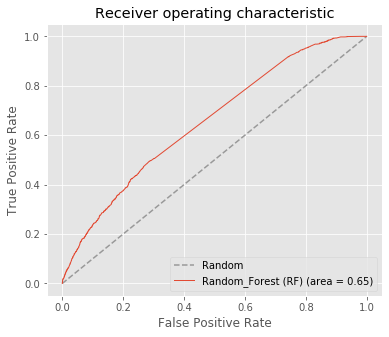

In [70]:
# rnd_smp = np.random.random_sample(len(X)) < 0.
fig, ax = plt.subplots(1, figsize=(6, 5))
#classifier_labels = ['Random_Forest (RF)', 'Balanced_RF']
#classifiers = {'Random_Forest (RF)': rf, 'Balanced_RF': brf}
for label, clf in clfs.items():
    plot_roc_nofit(ax, X_test, y_test, clf, label)

#### what if we [account for imbalanced nature of the data](https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/ensemble/plot_comparison_ensemble_classifier.html#sphx-glr-auto-examples-ensemble-plot-comparison-ensemble-classifier-py)?

In [71]:
brf = BalancedRandomForestClassifier(**model_param)
brf.fit(X_train, y_train)

/home/ubuntu/miniconda3/envs/ipy/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:591: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


BalancedRandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                               criterion='gini', max_depth=5, max_features=25,
                               max_leaf_nodes=None, max_samples=None,
                               min_impurity_decrease=0.0, min_samples_leaf=2,
                               min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=400,
                               n_jobs=-1, oob_score=True, random_state=30,
                               replacement=False, sampling_strategy='auto',
                               verbose=0, warm_start=False)

In [72]:
# include the model for comparisons
clfs['Balanced_RF'] = brf

In [73]:
# measure accuracy
print("\n R^2 score:", brf.score(X_test, y_test))
print(f'\n Out of bag score: {brf.oob_score_}')
y_predict = brf.predict(X_test)
np.sum(y_predict)


 R^2 score: 0.2976110545580559

 Out of bag score: 0.25659563048038425


33505

In [74]:
print("\n precision:", precision_score(y_test, y_predict))
print("    recall:", recall_score(y_test, y_predict))


 precision: 0.035964781375914044
    recall: 0.9026217228464419


<ipython-input-69-d9476ec26323>:44: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)
<ipython-input-69-d9476ec26323>:44: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)


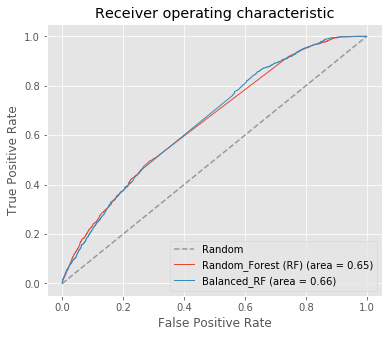

In [75]:
fig, ax = plt.subplots(1, figsize=(6, 5))
for label, clf in clfs.items():
    plot_roc_nofit(ax, X_test, y_test, clf, label)

In [76]:
def plot_roc(X, y, clf, plot_name, **kwargs):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    n_splits=5
    kf = KFold(n_splits=n_splits, shuffle=True)
    y_prob = np.zeros((len(y),2))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
#         clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y[test_index], y_prob[test_index, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='%s fold %d (area = %0.2f)' % (plot_name, i, roc_auc))
    mean_tpr /= n_splits
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# see `class_weight` parameter to treat unbalanced classes
# https://towardsdatascience.com/practical-tips-for-class-imbalance-in-binary-classification-6ee29bcdb8a7
model_param = {'n_estimators': 400,
#                    'max_depth': 5,
#                    'max_features': 25,
#                    'oob_score': True,
#                    'n_jobs': -1,
                   'random_state': 30,
#                    'class_weight': 'balanced_subsample'
              }

# mini_X_train.shape, mini_y_train.shape

cv_rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', 
                            max_depth=5, max_features=25, **model_param)
cv_gdbr = GradientBoostingClassifier(learning_rate=0.1, loss='ls', max_depth=5, 
                                 max_features=25, **model_param)
cv_abr = AdaBoostClassifier(DecisionTreeClassifier(), learning_rate=0.1,
                                 **model_param)

print("17. Use the included `plot_roc` function to visualize the roc curve of each model")
plot_roc(X_train, np.array(y_train), cv_rf, 'RandomForest')
plot_roc(X_train, np.array(y_train), cv_gdbr, 'GradientBoosting')
plot_roc(X_train, np.array(y_train), cv_abr, 'AdaBoost')


## model inspection

#### which features are important?


In [77]:
#Use sklearn's model to get the feature importances
feature_importances = np.argsort(rf.feature_importances_)
feature_names = np.array(tfidf_vectorizer.get_feature_names())
print("\n: top twenty:", list(feature_names[feature_importances[-1:-21:-1]]))
## top five: ['Day Mins', 'CustServ Calls', 'Day Charge', "Int'l Plan", 'Eve Mins']
## (will vary a little)


: top twenty: ['ok', 'agree', 'op', 'deleted', 'project', 'police', 'thanks', 'yeah', 'game', 'service', 'trump', 'state', 'news', 'eth', 'crypto', 'true', 'blockchain', 'think', 'giveaway', 'cop']


In [102]:
mask = np.array(['gt' in doc for doc in corpus])
np.array(corpus)[mask]

array(['oy now there nice quot out context gtone thought even more necessari limit popul properti limit fix calcul chanc mortal child steril marri person neglect subject exist state common neverfail caus poverti citizen poverti parent revolut crime sound big call take care decad under class more fix up cheap booz ciggi mate',
       'gt incomprehens speak incomprehens let talk your put word mouth youv agre scientif revolut origin christian thought youv noth unless enjoy watch yourself post bunch 888 aka your redditor',
       'gt read comment your read epic devast save face call name that real stori',
       ..., 'live tv httpwwwvgtvnoid55507',
       'differ use fish here fishprompt git function function fishgitinworkingtre true git revpars isinsideworktre devnul echo fals end function fishgitdirti not git diff noextdiff quiet exitcod devnul not git diffindex cach quiet head devnul count git lsfile other excludestandard devnul end function fishgitcurrenthead git symbolicref head devnu

In [103]:
for comm_author, comm_body, troll_label in zip(comms[mask]['author'], comms[mask]['body'], y[mask]):
    print(f'{comm_author} ... troll?: {troll_label}\n{comm_body}\n ------------ \n')

1488reasons ... troll?: 1
Oy now there's a nice quote out of context:

&gt;One would have thought that it was even more necessary to limit population than property; and that the limit should be fixed by calculating the chances of mortality in the children, and of sterility in married persons. The neglect of this subject, which in existing states is so common, is a never-failing cause of poverty among the citizens; and poverty is the parent of revolution and crime. 

Sounds like big A is calling on us to take care of the decadent under classes more than fixing them up with cheap booze and ciggies mate
 ------------ 

1488reasons ... troll?: 1
&gt; incomprehensible 

Speaking of incomprehensible, let's talk about why you're putting words in my mouth. If you've agreed that the scientific revolution originated in Christian thought, you've got nothing else to say to me unless you just enjoy watching yourself post a bunch of 888 (aka you're a redditor)
 ------------ 

1488reasons ... troll?:

#### Trolls like to include quotes in their replies, putting the `&gt;` at the beginning of lines in their comments

In [89]:
mask = np.array(['ayi' in doc for doc in corpus])
np.array(corpus)[mask]

array(['ive caught sayin bitconneeeeeeeeec mani time now', 'ayi lmao',
       'ayi lmao', '711 ayi', 'nm ayi', 'ayi yo', 'ayi', 'ayi',
       'ayi lmao', 'ayi le mao', 'ayi lmao', 'ayi updat lmao', 'ayi',
       'ayi lmao', '2941 ayi', 's1mple lanbot ayi lmao',
       'price dlc free justsayin', 'ayi lmao', 'ayi lmao', 'ayi rekt',
       'ayi lmao', '6711 ayi', 'ayi', 'c ayi', 'ayi lmao', 'ayi lmao',
       'ayi lmao', 'ayi lmao', 'ayi lmao',
       'payitforward friday definit post thread solicit request toooon peopl alway ask codeston train myself includ wander through 350 post made dure day look wishlist surprisegift thought worthwhil coupl user regular giveaway contest uspeeds03 random photoshoppoemwritingpickanumberetc contest week give out ub item favorit entrant ubeforeisleep food club bet competit day gift 5 dubloon coin winner there rneopet custom contest go halloween think theyr still solicit donat prize that someth youd particip sound realli awesom nice thank ad warmth suppo

In [101]:
for comm_author, comm_body, troll_label in zip(comms[mask]['author'], comms[mask]['body'], y[mask]):
    print(f'{comm_author} ... troll?: {troll_label}\n{comm_body}\n ------------ \n')


dandy1crown ... troll?: 1
I've been caught sayin bitconneeeeeeeeec so many times now 
 ------------ 

shomyo ... troll?: 1
Ayy Lmao
 ------------ 

shomyo ... troll?: 1
Ayy lmao
 ------------ 

shomyo ... troll?: 1
711 ayy
 ------------ 

shomyo ... troll?: 1
[NMS] ayy
 ------------ 

shomyo ... troll?: 1
Ayy Yo!
 ------------ 

shomyo ... troll?: 1
Ayy
 ------------ 

shomyo ... troll?: 1
Ayy
 ------------ 

shomyo ... troll?: 1
Ayy lmao
 ------------ 

shomyo ... troll?: 1
Ayy le mao!
 ------------ 

shomyo ... troll?: 1
Ayy lmao
 ------------ 

shomyo ... troll?: 1
AYY

Update:  LMAO
 ------------ 

shomyo ... troll?: 1
Ayy!
 ------------ 

shomyo ... troll?: 1
Ayy lmao!
 ------------ 

shomyo ... troll?: 1
2941

Ayy!
 ------------ 

shomyo ... troll?: 1
s1mple #lanBOT ayy lmao
 ------------ 

shomyo ... troll?: 1
With that price all dlc should be free.
*justsayin*
 ------------ 

shomyo ... troll?: 1
Ayy lmao
 ------------ 

shomyo ... troll?: 1
"Ayy Lmao"
 ------------ 

shomyo ..

#### ayyy lmao ...

In [105]:
mask = np.array(['tie' in doc for doc in corpus])
np.array(corpus)[mask]

array(['secular activ actual divorc rate illegitim birth disintegr not famili valu basic valu civic respons common decenc great sign secular valu arent do veri good job stare blankli iphon dope up ssri forget never see famili social tie speak post facebook ugh stupid xtian cant accept week new sexual orient realli big liber victori over mean ol patriarch religion',
       'progress ideolog border theolog peopl rootless cosmopolitan tie togeth consumpt habit one econom collaps have futur starvat street im sure be total notracist immens comfort liber welfar state collaps decad selfhatr',
       'gt peopl countri men woman serv countri fight feel kinship dont noth benefit unit state will potenti throw life away ideolog pal swede share close tie western civil variou swarthi hord invad dont that ought care dunno your get neocohen chickenhawk',
       ...,
       'thank kind sir wait eagerlyhttpwwwfunnyanimalsitecompicturespatientbearjpg',
       'prettiest pussi planetno doubt',
       'oh 

In [106]:
for comm_author, comm_body, troll_label in zip(comms[mask]['author'], comms[mask]['body'], y[mask]):
    print(f'{comm_author} ... troll?: {troll_label}\n{comm_body}\n ------------ \n')

1488reasons ... troll?: 1
What secular activities actually do this? Divorce rates, illegitimate births, and the disintegration of not just family values but basic values of civic responsibility and common decency are all a great sign that "secular values" aren't doing a very good job. 

Is staring blankly into an iPhone while doped up on SSRIs to forget how you never see your family and have no social ties to speak of while posting on Facebook about ugh stupid Xtians who can't accept this week's new sexual orientation really that big liberating victory over the mean ol' patriarchal religion?
 ------------ 

1488reasons ... troll?: 1
You have a progressive ideology that borders on a theology. Your "people" are rootless cosmopolitans who are tied together by consumption habits. You are one economic collapse from having your "future" be starvation in the streets. 

I'm sure being totally not-racist will be immense comfort when the liberal welfare states collapse because of decadence and s

#### crypto pump 'n dump (enigma and tie)

In [108]:
mask = np.array(['slave' in doc for doc in corpus])
np.array(corpus)[mask]

array(['hraium again rememb last season mother dragon danger be kill outrag slave dragon came fight sat vla mean fli one moment dragon look more real',
       'poli sci class teacher take slave never recogn constitut goe talk colonist ate class start name thing deer opossum rabbit ect keep mind african american student blurt out coon burger african american immedi realiz seem shock laugh class understand racial implic teacher immedi turn around look student lectur hall have hard time find student student start laugh student exclaim sorri not understand mistak student laugh far one more bizarrefunni moment occ',
       'well alradi think america great dure slaveri expect',
       'those accus racism real racist found slaveri theme there none',
       'slave mental polic state',
       'alway downvot butthurt brainwash slave', 'appl enjoy slaveri',
       'oh those spineless consol slave',
       'sure rt fake video go watch cnn fox propaganda spineless slave',
       'slave obey earthli

In [109]:
for comm_author, comm_body, troll_label in zip(comms[mask]['author'], comms[mask]['body'], y[mask]):
    print(f'{comm_author} ... troll?: {troll_label}\n{comm_body}\n ------------ \n')

King_Andersons ... troll?: 1
hraium, say it again. 
I remember the last season, when Mother of Dragons was in danger of being killed by the outraged slaves and the dragon came to fight for her and she sat on it and said "Vla" which means "fly". It was one of the moments the Dragons looked more real than ever.
 ------------ 

georgepharell ... troll?: 1
At my poly sci class, my teacher was taking about how slaves were never recognized in the constitution, then he goes on to talk about what the colonist ate. So the class starts naming things like deer and opossum, rabbits, ect. Keep in mind he is African American. Then a students blurts out coon burger, she also is African American and immediately realizes what she said and seems shocked but also laughing . Some of the class understand the racial implication but the teacher immediately turns around and looks for the student who said it. Its a lecture hall so he was having a hard time finding the student but some students start laughing a

#### america sux, you're all slaves to the police state

In [110]:
mask = np.array(['obey' in doc for doc in corpus])
np.array(corpus)[mask]

array(['cop gotten ear without necessarili taser she goddamn old christ sake offic around couldnt handcuff ear think taser fall break arm lame arent cop train act better such situat old woman tase littl resist obey instruct till point take jewel dont be procedur man serious lame cop train shoot tase that common guy',
       'european union regul obey', 'obey',
       'stop resist obey polic state', 'obey', 'obey', 'obey', 'obey',
       'obey', 'obey', 'american okay obey polic state', 'obey', 'obey',
       'obey', 'obey', 'slave obey earthli master respect fear',
       'gt texa illeg child unusu haircut obey',
       'sourc come cop famili ive work cop know mani polici both work be polic explor im not say im profession mean opinion experi good opinion actual cop httpwwwredditcomrvideoscomments1hgt7ehawthornecapoliceofficersapparentlyshootdogcaua1o9 cop wrong mani point ye plain simpl owner better seen court made mistak drove up blare loud music offic use bullhorn tell traffic move a

In [111]:
for comm_author, comm_body, troll_label in zip(comms[mask]['author'], comms[mask]['body'], y[mask]):
    print(f'{comm_author} ... troll?: {troll_label}\n{comm_body}\n ------------ \n')

Maxwel_Terry ... troll?: 1
The cops could have gotten the earrings off without necessarily tasering her. shes goddamn old for Christ sake. there were other officers around. couldn't they just handcuff her and get the earrings off? i think tasering her to fall (break arm) was just too lame. arent cops trained to act better in such situations (with old women) than to just tase after after a little resistance. she obeyed all instructions till the point of taking off her jewels. i just dont get this as a being a procedure man. Its seriously lame. Like cops are trained to shoot and tase and thats all... common guys!! 
 ------------ 

shomyo ... troll?: 1
European Union regulations. 
OBEY.

 ------------ 

shomyo ... troll?: 1
OBEY
 ------------ 

shomyo ... troll?: 1
Stop resisting. OBEY.
Police state.
 ------------ 

shomyo ... troll?: 1
OBEY
 ------------ 

shomyo ... troll?: 1
OBEY


 ------------ 

shomyo ... troll?: 1
OBEY
 ------------ 

shomyo ... troll?: 1
OBEY
 ------------ 

shomy

#### obey your masters, americans

### partial dependence on the top 10 words

In [81]:
# repeated from above, for reminder
# feature_importances = np.argsort(rf.feature_importances_)
# feature_names = np.array(tfidf_vectorizer.get_feature_names())

top_n_features = 100
top_feature_index = feature_importances[-1:-top_n_features-1:-1]
top_feature_names = feature_names[top_feature_index]
top_feature_index, top_feature_names

(array([295,  15, 298, 109, 335, 324, 422, 495, 159, 375, 439, 398, 288,
        129,  95, 438,  46, 426, 164,  89, 272, 133, 128, 435,  44, 132,
        230, 158, 218, 423, 101, 300, 404,  78, 311, 191, 440,  93, 331,
        286, 235, 402, 232, 390,  82, 340, 171, 210,  91,  24, 175, 234,
         65, 319, 173, 360, 289, 213,  71, 178, 124, 131, 196, 309, 137,
        120, 262, 193, 241, 411, 104, 343, 140, 430, 251, 253, 388, 287,
        216,  38,  69, 143, 453,  77,  41, 258, 126, 327,  45,   0, 333,
        185, 342, 353, 215, 259, 412, 108, 428, 456]),
 array(['ok', 'agree', 'op', 'deleted', 'project', 'police', 'thanks',
        'yeah', 'game', 'service', 'trump', 'state', 'news', 'eth',
        'crypto', 'true', 'blockchain', 'think', 'giveaway', 'cop',
        'medium', 'exchange', 'especially', 'trading', 'bitcoin',
        'example', 'know', 'future', 'interesting', 'thats', 'cute',
        'opinion', 'story', 'coin', 'people', 'heard', 'try', 'course',
        'price', 'ne

In [82]:
X_train[::42].shape

(4398, 500)


: top 100: ['ok', 'agree', 'op', 'deleted', 'project', 'police', 'thanks', 'yeah', 'game', 'service', 'trump', 'state', 'news', 'eth', 'crypto', 'true', 'blockchain', 'think', 'giveaway', 'cop', 'medium', 'exchange', 'especially', 'trading', 'bitcoin', 'example', 'know', 'future', 'interesting', 'thats', 'cute', 'opinion', 'story', 'coin', 'people', 'heard', 'try', 'course', 'price', 'need', 'le', 'stop', 'late', 'sorry', 'community', 'read', 'good', 'idea', 'country', 'article', 'guess', 'law', 'care', 'play', 'great', 'russian', 'nice', 'im', 'change', 'haha', 'edit', 'exactly', 'history', 'pay', 'fact', 'ea', 'major', 'help', 'life', 'support', 'day', 'really', 'fan', 'time', 'lol', 'look', 'small', 'new', 'information', 'best', 'cause', 'feel', 'value', 'close', 'big', 'lot', 'enjoy', 'post', 'black', '10', 'problem', 'hard', 'real', 'right', 'important', 'love', 'sure', 'definitely', 'thought', 'video']


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


ValueError: percentiles are too close to each other, unable to build the grid. Please choose percentiles that are further apart.

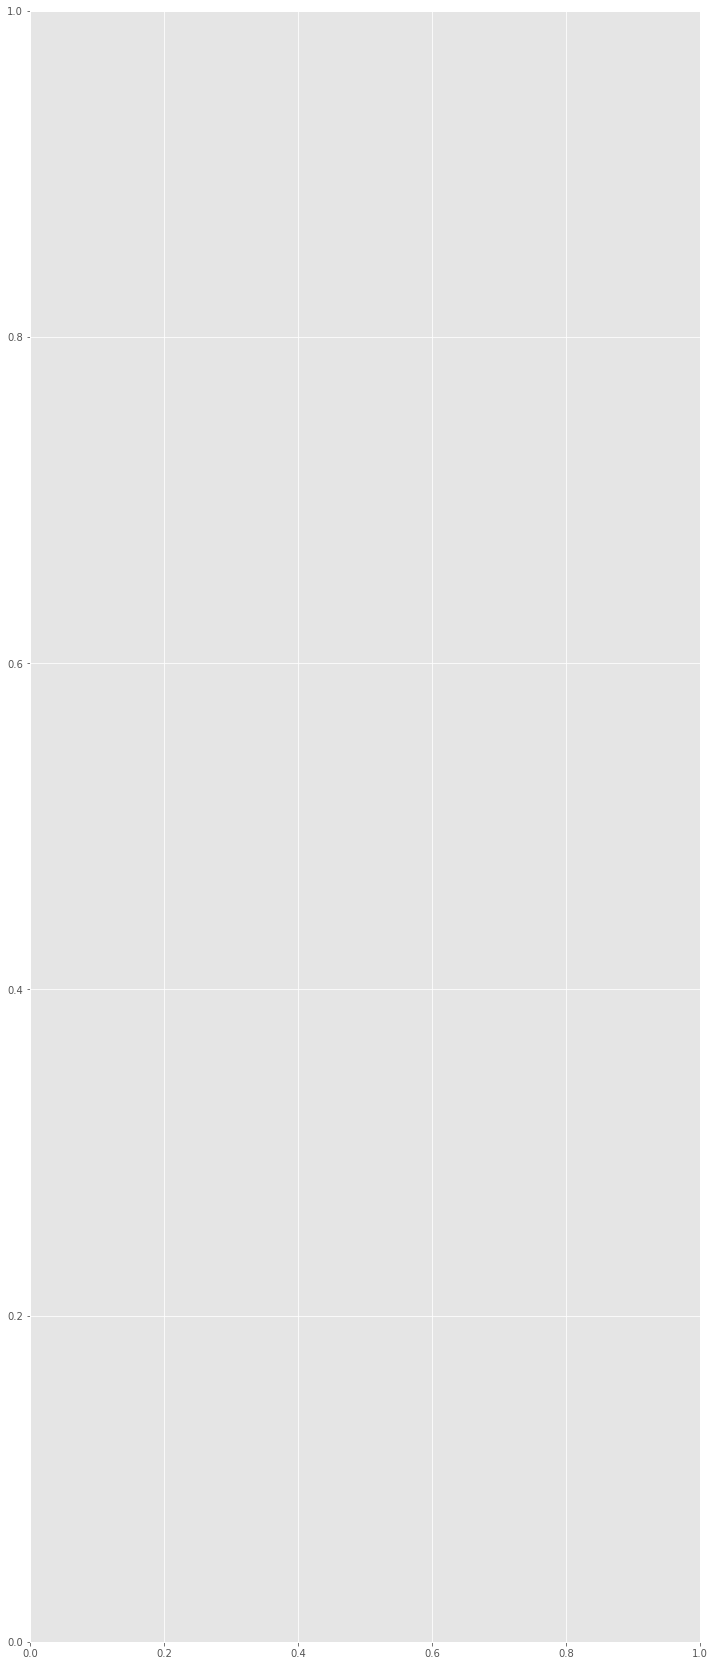

In [83]:
# partial dependence, you suck

print(f'\n: top {top_n_features}:', list(top_feature_names))
tic = time.time()
fig, ax = plt.subplots(1, 1, figsize=(12, 30))
plot_partial_dependence(rf, 
                        X_train.T[top_feature_index].T, 
                        np.arange(top_n_features), 
                        feature_names=top_feature_names, 
                        n_jobs=-1,
                        verbose=1,
                        ax=ax)
print("done in {:.3f}s".format(time.time() - tic))
fig.suptitle('Partial dependence of troll? on word usage in random forest model')
fig.tight_layout()
plt.savefig('img/model_v2_top' + str(top_n_features) + '_partial_dep.png')

In [84]:
len(X_test)

46171

In [91]:
# what about permutation importance
# took 20 minutes, ~24 GB RAM, and ~15 cores
# this ultimately failed because the permutation importances were all 0
result = permutation_importance(rf, X_test[::10], y_test[::10], n_repeats=3,
                                random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

In [92]:
sorted_idx

array([  0, 341, 340, 339, 338, 337, 336, 335, 334, 333, 332, 331, 330,
       329, 328, 327, 326, 325, 324, 323, 322, 321, 320, 319, 318, 317,
       316, 315, 342, 314, 343, 345, 372, 371, 370, 369, 368, 367, 366,
       365, 364, 363, 362, 361, 360, 359, 358, 357, 356, 355, 354, 353,
       352, 351, 350, 349, 348, 347, 346, 344, 313, 312, 311, 278, 277,
       276, 275, 274, 273, 272, 271, 270, 269, 268, 267, 266, 265, 264,
       263, 262, 261, 260, 259, 258, 257, 256, 255, 254, 253, 252, 279,
       280, 281, 282, 310, 309, 308, 307, 306, 305, 304, 303, 302, 301,
       300, 299, 298, 373, 297, 295, 294, 293, 292, 291, 290, 289, 288,
       287, 286, 285, 284, 283, 296, 251, 374, 376, 466, 465, 464, 463,
       462, 461, 460, 459, 458, 457, 456, 455, 454, 453, 452, 451, 450,
       449, 448, 447, 446, 445, 444, 443, 442, 441, 440, 467, 439, 468,
       470, 497, 496, 495, 494, 493, 492, 491, 490, 489, 488, 487, 486,
       485, 484, 483, 482, 481, 480, 479, 478, 477, 476, 475, 47

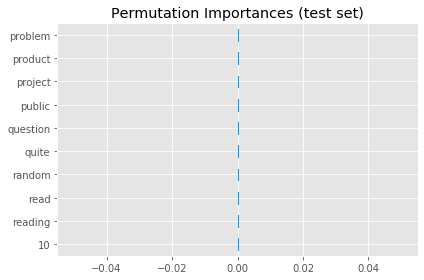

In [93]:
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx][:10].T,
           vert=False, labels=feature_names[sorted_idx][:10])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

## new stop words?:

* gt -- part of `&gt;`, the html-encoding calling out quoted text in a comment ...
* ok
* thank
* yeah
* ayi -- part of ayyy lmao

In [ ]:
np.random.random_choice(X_test)

# Naive Bayes Classifier

Recall from lecture, a shorthand difference between Bayesian and Frequentist statistics

* Bayesianist says, there are many hypotheses, each one with some probability of being true
* Frequentist says, there is one true hypothesis, we'll just never know what it is.

[bayes theorem picture labeled with prior, posterior, likelihood, and normalizing factor]

* Bayesian approach gives us somewhat more intuitive approach to hypothesis testing when there are multiple alternative hypotheses. 

* prior is the fraction of the observations in the training data that belong to the class
* posterior is the probability of the class given the observations
* likelihood is the probability of the observations given the class

### Notation



say we want to classify emails as spam or not spam. We need a classifier that is fast, even on high-dimensional data -- naive bayes is a reasonable choice. 



In [56]:
from scipy import stats
import numpy as np
import pandas as pd

In [51]:
# flip "four" coins
# class 1, four independent coins
# class 2, three independent coins with fourth majority vote from first three

def flip_coins(n):
    return stats.bernoulli(0.5).rvs(n)

def legit(n_trials):
    return flip_coins(4)

def lazy(n_trials, n_lazy):
    n_minus_lazy_flips = flip_coins(n_trials-n_lazy)
    lazy_flip = 0
    if np.mean(n_minus_lazy_flips) > 0.5:
        lazy_flip = 1
    lazy_flips = np.array([lazy_flip]* n_lazy)
    return np.hstack([n_minus_lazy_flips, lazy_flips])
    

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8a90542e20>,
      dtype=object)

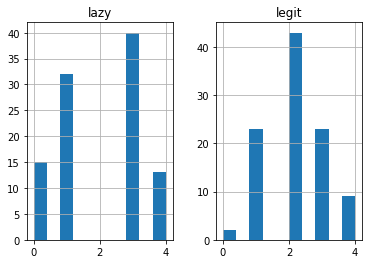

In [58]:
myli = []
for i in range(100):
    myli.append({'lazy': np.sum(lazy(4, 1)), 'legit': np.sum(legit(4))})
flips_df = pd.DataFrame(myli)
flips_df.hist()

In [37]:
twenty_perc = stats.bernoulli(0.2).rvs(1000)
eighty_perc = stats.bernoulli(0.8).rvs(1000)
np.sum(twenty_perc), np.sum(eighty_perc)

(186, 802)